In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter
import shutil

Estimated phase speed cp ≈ 3.130, group speed cg ≈ 1.567 (deep-water ⇒ cg ≈ 0.5 cp)


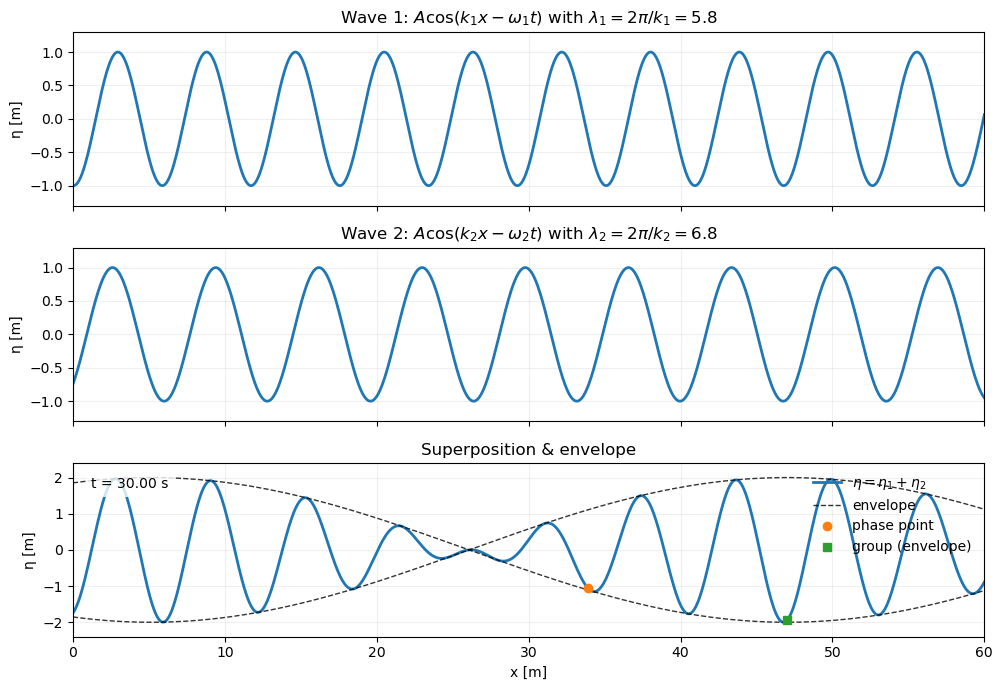

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter
import shutil

# ---------------- physics setup ----------------
g = 9.81
def omega(k):         # deep-water gravity-wave dispersion
    return np.sqrt(g*k)

A   = 1.0
k0  = 1.0             # central wavenumber [1/m]
dk  = 0.15            # small separation -> clear beats
k1, k2 = k0 + dk/2, k0 - dk/2
w1, w2 = omega(k1), omega(k2)

cp = (w1 + w2)/(k1 + k2)          # phase speed near k0
cg = (w2 - w1)/(k2 - k1)          # finite-diff group speed

# ---------------- numerical grid ----------------
Lx = 60.0
nx = 1200
x = np.linspace(0, Lx, nx)
tmax = 30.0
nt = 720
t = np.linspace(0, tmax, nt)

# ---------------- figure ----------------
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
(ax1, ax2, ax3) = axes

# Lines for each panel
ln1,  = ax1.plot([], [], lw=2)                                       # η1
ln2,  = ax2.plot([], [], lw=2)                                       # η2
ln3,  = ax3.plot([], [], lw=2, label=r'$\eta=\eta_1+\eta_2$')        # η = η1+η2
envL, = ax3.plot([], [], 'k--', lw=1, alpha=0.8, label='envelope')
envR, = ax3.plot([], [], 'k--', lw=1, alpha=0.8)
phase_marker, = ax3.plot([], [], 'o', ms=6, label='phase point')
group_marker, = ax3.plot([], [], 's', ms=6, label='group (envelope)')

# Time counter (placed on bottom panel)
time_text = ax3.text(0.02, 0.92, "", transform=ax3.transAxes,
                     ha="left", va="top",
                     bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"))

# Titles & labels (with units)
ax1.set_title(rf"Wave 1: $A\cos(k_1 x-\omega_1 t)$ with $\lambda_1 = 2 \pi/k_1 = {np.round(2*np.pi/k1, 1)}$")
ax2.set_title(rf"Wave 2: $A\cos(k_2 x-\omega_2 t)$ with $\lambda_2 = 2 \pi/k_2 = {np.round(2*np.pi/k2, 1)}$")
ax3.set_title("Superposition & envelope")

for ax in axes:
    ax.set_xlim(0, Lx)
    ax.grid(True, alpha=0.2)
    ax.set_ylabel("η [m]")        # y-label on all three panels

ax1.set_ylim(-1.3*A, 1.3*A)
ax2.set_ylim(-1.3*A, 1.3*A)
ax3.set_ylim(-2.4*A, 2.4*A)

ax3.set_xlabel("x [m]")          # x-label only on the bottom panel
ax3.legend(loc="upper right", frameon=False)

# Precompute stationary envelope shape, then shift by c_g t
def envelope(xshift):
    return 2*A*np.cos(0.5*dk*(x - xshift))

def init():
    ln1.set_data([], [])
    ln2.set_data([], [])
    ln3.set_data([], [])
    envL.set_data([], [])
    envR.set_data([], [])
    phase_marker.set_data([], [])
    group_marker.set_data([], [])
    time_text.set_text("")
    return ln1, ln2, ln3, envL, envR, phase_marker, group_marker, time_text

def animate(i):
    ti = t[i]
    eta1 = A*np.cos(k1*x - w1*ti)
    eta2 = A*np.cos(k2*x - w2*ti)
    eta  = eta1 + eta2

    # Top & middle panels
    ln1.set_data(x, eta1)
    ln2.set_data(x, eta2)

    # Bottom panel (sum + envelope + markers)
    ln3.set_data(x, eta)

    x_group = (cg*ti) % Lx
    env = envelope(x_group)
    envL.set_data(x,  env)
    envR.set_data(x, -env)

    # A phase reference: crest moving at ~c_p
    x_phase = (cp*ti) % Lx
    y_phase = np.interp(x_phase, x, eta)

    phase_marker.set_data([x_phase], [y_phase])
    group_marker.set_data([x_group], [np.interp(x_group, x, eta)])

    # Update time counter with units
    time_text.set_text(f"t = {ti:5.2f} s")

    return ln1, ln2, ln3, envL, envR, phase_marker, group_marker, time_text

ani1 = FuncAnimation(fig, animate, frames=nt, init_func=init, interval=40, blit=True)
plt.tight_layout()

writer = FFMpegWriter(fps=30, bitrate=1800)
ani1.save("beats_phase_vs_group.mp4", writer=writer)

print(f"Estimated phase speed cp ≈ {cp:.3f}, group speed cg ≈ {cg:.3f} (deep-water ⇒ cg ≈ 0.5 cp)")

# In-notebook display (works because ffmpeg is present)
from IPython.display import HTML
HTML(ani1.to_html5_video())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

# ---------- physics: deep-water gravity waves ----------
g = 9.81
def omega(k): return np.sqrt(g*k)           # ω(k)
def cg(k):    return 0.5*np.sqrt(g/k)       # dω/dk = 1/2 sqrt(g/k)
def cp(k):    return np.sqrt(g/k)           # ω/k

# carrier (choose k0; everything else from deep-water theory)
k0   = 1.0                    # central wavenumber [1/m]
w0   = omega(k0)              # frequency at k0
cg0  = cg(k0)                 # group velocity
cp0  = cp(k0)                 # phase speed
lam0 = 2*np.pi/k0
d2w0 = -0.25*np.sqrt(g/k0**3) # exact ω''(k0) (deep water)

# ---------- spreading Gaussian envelope a(x, t) ----------
# initial spatial width sigma0 (choose a bit larger than λ0 to satisfy scale separation)
sigma0 = 6.0                  # [m] initial 1/e half-width of the Gaussian
A0     = 1.0                  # overall amplitude scale

def envelope_gaussian(x, xc, t):
    """Analytic narrow-band result with quadratic dispersion: a(x,t) Gaussian whose
       width grows as sigma_x(t) and whose amplitude rescales by sigma0/sigma_t."""
    sigma_t = np.sqrt(sigma0**2 + (d2w0*t)**2 / sigma0**2)
    a = A0 * (sigma0 / sigma_t) * np.exp(-0.5 * ((x - xc)/sigma_t)**2)
    return a

# ---------- grids ----------
Lx = 120.0
nx = 2000
x  = np.linspace(-Lx/4, 3*Lx/4, nx)

tmax = 40.0                   # physical time span [s]
nt   = 300
t    = np.linspace(0, tmax, nt)

# ---------- figure ----------
fig, ax = plt.subplots(figsize=(9, 4))
line,     = ax.plot([], [], lw=2, label="wave")
env_line, = ax.plot([], [], "k--", lw=1.5, alpha=0.9, label=r"envelope $a(x,t)$")
phase_dot, = ax.plot([], [], "o", ms=6, label="phase (crest)")
group_square, = ax.plot([], [], "s", ms=6, label="group center")

ax.set_title(r"Dispersive Gaussian packet (deep water): envelope moves at $c_g$ and spreads")
ax.set_xlim(x.min(), x.max())
ax.set_ylim(-1.75, 1.75)
ax.grid(True, alpha=0.2)
ax.set_xlabel("x [m]")
ax.set_ylabel("η [m]")
ax.legend(loc="upper right", frameon=False)

time_text = ax.text(0.02, 0.95, "", transform=ax.transAxes,
                    ha="left", va="top",
                    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"))

# ---------- animation kernels ----------
def init():
    line.set_data([], [])
    env_line.set_data([], [])
    phase_dot.set_data([], [])
    group_square.set_data([], [])
    time_text.set_text("")
    return line, env_line, phase_dot, group_square, time_text

def animate(i):
    ti = t[i]
    # envelope center translating at c_g and spreading via ω''
    xc = cg0 * ti
    a  = envelope_gaussian(x, xc, ti)
    eta = a * np.cos(k0*x - w0*ti)   # ψ ≈ Re{e^{i(k0 x - ω0 t)} a(x,t)}

    # update artists
    line.set_data(x, eta)
    env_line.set_data(x, a)

    # group marker at envelope peak
    group_square.set_data([xc], [np.interp(xc, x, a)])

    # phase marker: crest near center (phase slip (cp - cg) t modulo λ0)
    x_phase = xc + ((cp0 - cg0) * ti) % lam0
    phase_dot.set_data([x_phase], [np.interp(x_phase, x, eta)])

    # annotate time and instantaneous width
    sigma_t = np.sqrt(sigma0**2 + (d2w0*ti)**2 / sigma0**2)
    time_text.set_text(
        rf"$t = {ti:5.2f}$ s   "
        rf"$c_p={cp0:.2f}$ m/s, $c_g={cg0:.2f}$ m/s,  "
        rf"$\sigma_x(t)={sigma_t:.2f}$ m"
    )

    return line, env_line, phase_dot, group_square, time_text

ani2 = FuncAnimation(fig, animate, frames=nt, init_func=init, interval=80, blit=True)
plt.tight_layout()

# Save (ffmpeg MP4). Lower fps ⇒ slower playback.
ani2.save("packet_quadratic_spreading.mp4", writer=FFMpegWriter(fps=15, bitrate=1800))

from IPython.display import HTML
HTML(ani2.to_html5_video())    # requires ffmpeg
